In [1]:
# ============================================================================
# SETUP
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

print("✅ Libraries imported!\n")

Mounted at /content/drive
✅ Libraries imported!



In [2]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("📂 Loading preprocessed data...")

DATA_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Processed_Data'
MODELS_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Models'
RESULTS_DIR = '/content/drive/MyDrive/EAI6010_Final Project/Results/Baseline'

import os
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load data
train_df = pd.read_csv(f'{DATA_DIR}/train_processed.csv')
val_df = pd.read_csv(f'{DATA_DIR}/val_processed.csv')

print(f"✅ Train: {len(train_df):,} samples")
print(f"✅ Val: {len(val_df):,} samples\n")

# Prepare data
X_train = train_df['clean_title'].values
y_train = train_df['2_way_label'].values
X_val = val_df['clean_title'].values
y_val = val_df['2_way_label'].values

📂 Loading preprocessed data...
✅ Train: 45,414 samples
✅ Val: 9,090 samples



In [3]:
# ============================================================================
# FEATURE EXTRACTION
# ============================================================================
print("="*70)
print("🔧 FEATURE EXTRACTION")
print("="*70 + "\n")

print("Creating TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print(f"✅ TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"   Vocabulary size: {len(vectorizer.vocabulary_):,}\n")

🔧 FEATURE EXTRACTION

Creating TF-IDF features...
✅ TF-IDF feature shape: (45414, 5000)
   Vocabulary size: 5,000



In [4]:
# ============================================================================
# MODEL TRAINING
# ============================================================================
print("="*70)
print("🤖 TRAINING BASELINE MODELS")
print("="*70 + "\n")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")

    # Train
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    train_time = time.time() - start_time

    # Predict
    y_pred = model.predict(X_val_tfidf)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Train Time (s)': train_time
    })

    print(f"  ✅ Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Time: {train_time:.1f}s\n")

    # Save model
    model_path = f'{MODELS_DIR}/{name.replace(" ", "_").lower()}_model.pkl'
    joblib.dump(model, model_path)

🤖 TRAINING BASELINE MODELS

Training Logistic Regression...
  ✅ Accuracy: 0.7538 | F1: 0.7026 | Time: 1.2s

Training Naive Bayes...
  ✅ Accuracy: 0.7484 | F1: 0.6979 | Time: 0.0s

Training Random Forest...
  ✅ Accuracy: 0.7362 | F1: 0.6919 | Time: 178.8s

Training Linear SVM...
  ✅ Accuracy: 0.7570 | F1: 0.7140 | Time: 0.2s



In [5]:
# ============================================================================
# RESULTS COMPARISON
# ============================================================================
print("="*70)
print("📊 RESULTS COMPARISON")
print("="*70 + "\n")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print(results_df.to_string(index=False))
print()

# Save results
results_df.to_csv(f'{RESULTS_DIR}/baseline_results.csv', index=False)
print(f"✅ Saved results to: baseline_results.csv\n")

📊 RESULTS COMPARISON

              Model  Accuracy  Precision   Recall  F1-Score  Train Time (s)
         Linear SVM  0.756986   0.728017 0.700457  0.713971        0.212316
Logistic Regression  0.753795   0.736490 0.671748  0.702631        1.220302
        Naive Bayes  0.748405   0.726823 0.671240  0.697926        0.021844
      Random Forest  0.736194   0.699948 0.683943  0.691853      178.771642

✅ Saved results to: baseline_results.csv



📊 Creating visualizations...



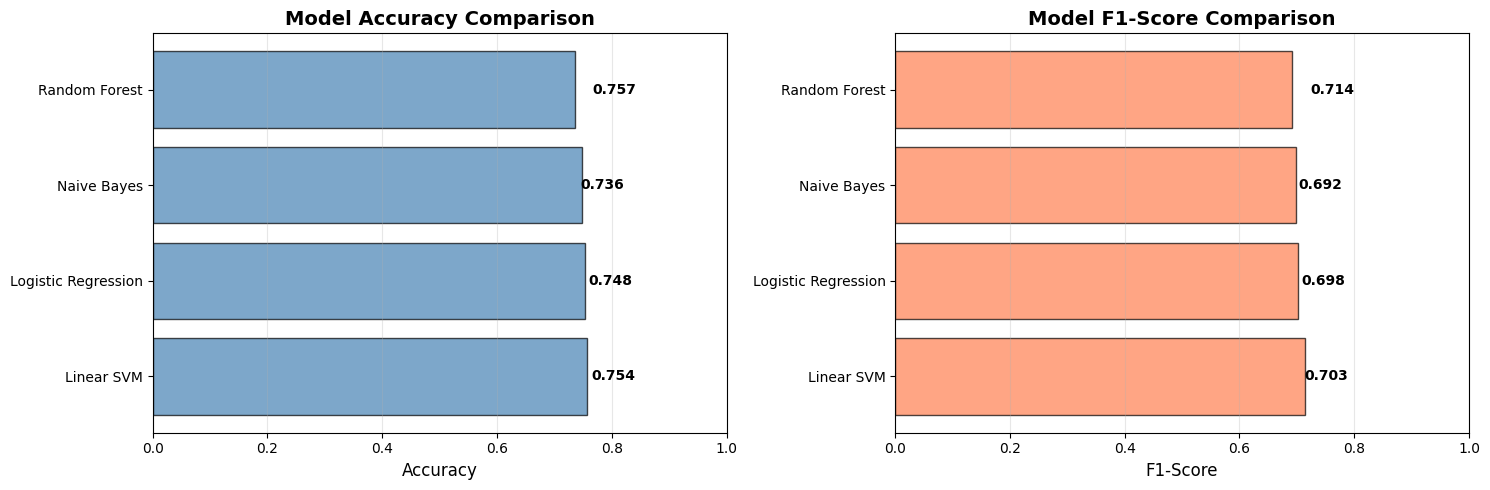

✅ Saved: baseline_comparison.png



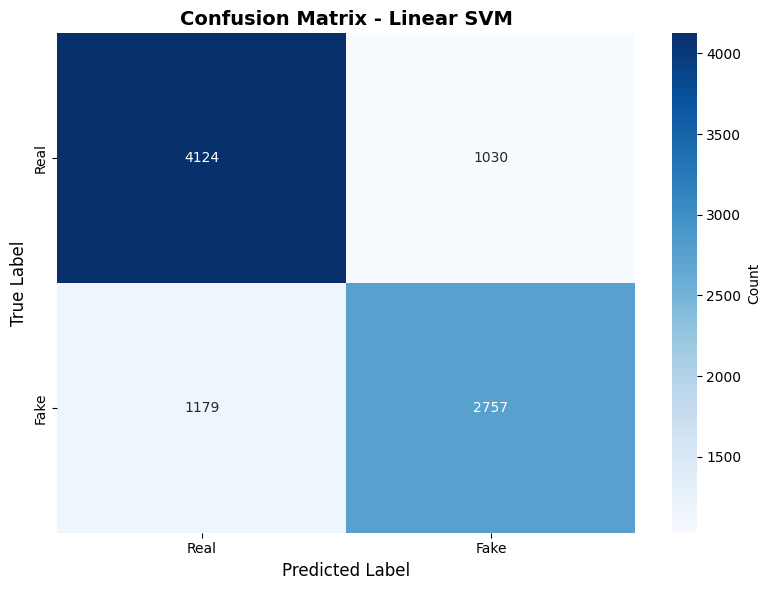

✅ Saved: best_baseline_confusion_matrix.png



In [6]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("📊 Creating visualizations...\n")

# Plot 1: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
axes[0].barh(results_df['Model'], results_df['Accuracy'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', alpha=0.3)

# Add values on bars
for idx, row in results_df.iterrows():
    axes[0].text(row['Accuracy'] + 0.01, idx, f"{row['Accuracy']:.3f}",
                va='center', fontsize=10, fontweight='bold')

# F1-Score comparison
axes[1].barh(results_df['Model'], results_df['F1-Score'], color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 1)
axes[1].grid(axis='x', alpha=0.3)

for idx, row in results_df.iterrows():
    axes[1].text(row['F1-Score'] + 0.01, idx, f"{row['F1-Score']:.3f}",
                va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: baseline_comparison.png\n")

# Plot 2: Confusion Matrix for Best Model
best_model_name = results_df.iloc[0]['Model']
best_model = joblib.load(f'{MODELS_DIR}/{best_model_name.replace(" ", "_").lower()}_model.pkl')
y_pred_best = best_model.predict(X_val_tfidf)

cm = confusion_matrix(y_val, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/best_baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: best_baseline_confusion_matrix.png\n")

In [7]:
# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================
print("="*70)
print(f"📋 DETAILED REPORT - {best_model_name}")
print("="*70 + "\n")

report = classification_report(y_val, y_pred_best, target_names=['Real', 'Fake'])
print(report)

📋 DETAILED REPORT - Linear SVM

              precision    recall  f1-score   support

        Real       0.78      0.80      0.79      5154
        Fake       0.73      0.70      0.71      3936

    accuracy                           0.76      9090
   macro avg       0.75      0.75      0.75      9090
weighted avg       0.76      0.76      0.76      9090



In [8]:
# ============================================================================
# FEATURE IMPORTANCE (for Logistic Regression)
# ============================================================================
if 'Logistic Regression' in best_model_name:
    print("\n" + "="*70)
    print("🔍 TOP 20 MOST IMPORTANT WORDS")
    print("="*70 + "\n")

    # Get feature names and coefficients
    feature_names = vectorizer.get_feature_names_out()
    coef = best_model.coef_[0]

    # Top positive (fake news indicators)
    top_fake_indices = coef.argsort()[-10:][::-1]
    print("Top 10 Fake News Indicators:")
    for idx in top_fake_indices:
        print(f"  • {feature_names[idx]:20s} (weight: {coef[idx]:.3f})")

    print()

    # Top negative (real news indicators)
    top_real_indices = coef.argsort()[:10]
    print("Top 10 Real News Indicators:")
    for idx in top_real_indices:
        print(f"  • {feature_names[idx]:20s} (weight: {coef[idx]:.3f})")
    print()

In [9]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*70)
print("🎉 BASELINE TRAINING COMPLETE!")
print("="*70)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"\n📁 Saved files:")
print(f"   • Models: {MODELS_DIR}/")
print(f"   • Results: {RESULTS_DIR}/")

🎉 BASELINE TRAINING COMPLETE!

🏆 Best Model: Linear SVM
   Accuracy: 0.7570
   F1-Score: 0.7140

📁 Saved files:
   • Models: /content/drive/MyDrive/EAI6010_Final Project/Models/
   • Results: /content/drive/MyDrive/EAI6010_Final Project/Results/Baseline/


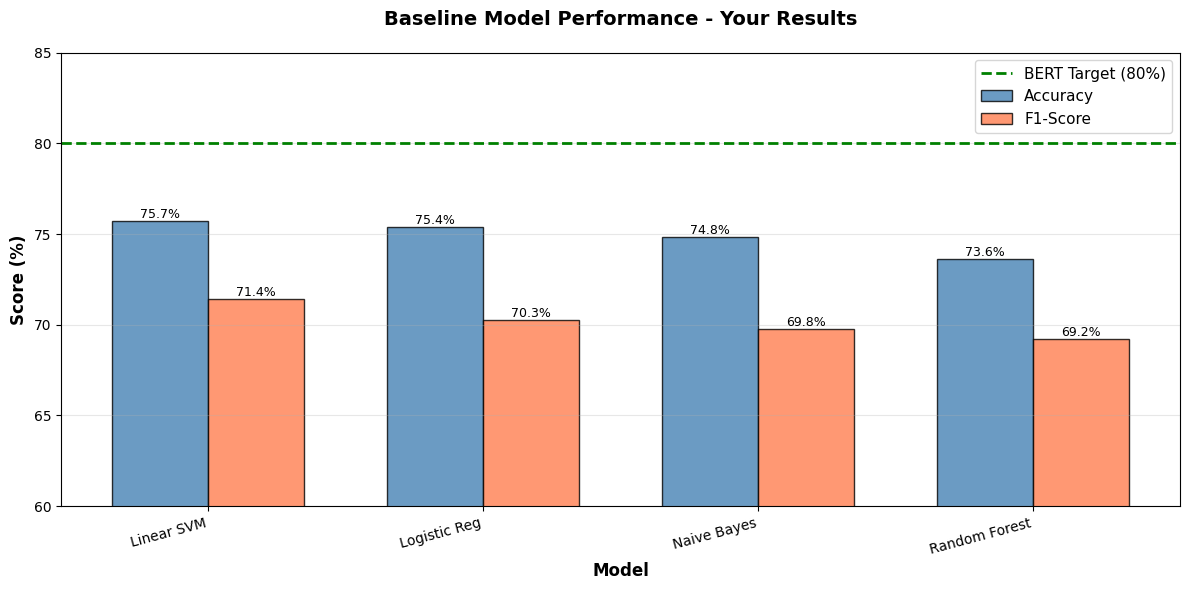

✅ Saved: my_results.png


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your results
results = {
    'Model': ['Linear SVM', 'Logistic Reg', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [75.70, 75.38, 74.84, 73.62],
    'F1-Score': [71.40, 70.26, 69.79, 69.19],
    'BERT Target': [80, 80, 80, 80]  # Target line
}

df = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df['Model']))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], df['Accuracy'], width,
               label='Accuracy', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], df['F1-Score'], width,
               label='F1-Score', color='coral', alpha=0.8, edgecolor='black')

# Add BERT target line
ax.axhline(y=80, color='green', linestyle='--', linewidth=2, label='BERT Target (80%)')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Baseline Model Performance - Your Results', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(60, 85)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EAI6010_Final Project/Results/Baseline/my_results.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: my_results.png")